In [44]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
import re
import string

In [45]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Triary Labels

In [46]:
df = pd.read_csv("airlinetweets.csv", encoding="ISO-8859-1")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [47]:
labels = df["airline_sentiment"]
inputs = df["text"]

In [48]:
inputs

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [49]:
def cleaner(impure_data):
    temp_list = []
    for item in impure_data:
        #finding words which start with @
        item = re.sub('@\S+', '', item)
        #finding words which start with http
        item = re.sub('http\S+\s*', '', item)
        temp_list.append(item)
    return temp_list

In [50]:
inputs = cleaner(inputs)
lemma = WordNetLemmatizer()
inputs

[' What  said.',
 " plus you've added commercials to the experience... tacky.",
 " I didn't today... Must mean I need to take another trip!",
 ' it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 " and it's a really big bad thing about it",
 " seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 ' yes, nearly every time I fly VX this â\x80\x9cear wormâ\x80\x9d wonâ\x80\x99t go away :)',
 ' Really missed a prime opportunity for Men Without Hats parody, there. ',
 " Well, I didn'tâ\x80¦but NOW I DO! :-D",
 " it was amazing, and arrived an hour early. You're too good to me.",
 ' did you know that suicide is the second leading cause of death among teens 10-24',
 ' I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 " This is such a great deal! Already thinking about my 2nd trip to  &amp; I haven't even gone on my 1st trip yet! ;p",
 "

In [51]:
def preprocess(impure_data):
    temp_list = []
    for input_ in impure_data:
        input_ = input_.strip().lower()
        if input_:
            input_ = input_.translate(str.maketrans('', '', string.punctuation))
            input_ = word_tokenize(input_)
            def get_wordnet_pos(treebank_tag):
                if treebank_tag.startswith("J"):
                    return wordnet.ADJ
                elif treebank_tag.startswith("V"):
                    return wordnet.VERB
                elif treebank_tag.startswith("R"):
                    return wordnet.ADV
                else:
                    return wordnet.NOUN
            words_and_tags = nltk.pos_tag(input_)
            input_ = [lemma.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
            input_ = [t for t in input_ if len(t) > 2]
            input_ = [t for t in input_ if not any(c.isdigit() for c in t)]
            input_ = " ".join(input_)
            temp_list.append(input_)
    return temp_list

In [52]:
ipts_ = preprocess(inputs)

In [53]:
df["cleaned_texts"] = ipts_
df["cleaned_texts"]

0                                                 what say
1         plus youve added commercial the experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                           and really big bad thing about
                               ...                        
14635               thank you get different flight chicago
14636    leave over minute late flight warning communic...
14637                        please bring american airline
14638    you have money you change flight and dont answ...
14639    have ppl need know how many seat the next flig...
Name: cleaned_texts, Length: 14640, dtype: object

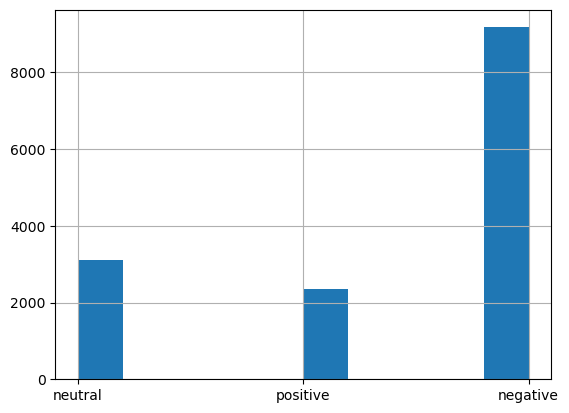

In [54]:
df["airline_sentiment"].hist();

In [55]:
df["b_labels"] = df["airline_sentiment"].map({"neutral": 0, "positive": 2, "negative": 1})

In [56]:
data = df["cleaned_texts"]
labels = df["b_labels"].to_numpy()
train_x, test_x, Ytrain, Ytest = train_test_split(data, labels, test_size=0.33)

In [57]:
vectorizer = TfidfVectorizer(stop_words="english")
Xtrain = vectorizer.fit_transform(train_x)
Xtest = vectorizer.transform(test_x)

In [58]:
Xtrain

<9808x8073 sparse matrix of type '<class 'numpy.float64'>'
	with 69983 stored elements in Compressed Sparse Row format>

In [59]:
model = LogisticRegression(max_iter=1000)
model.fit(Xtrain, Ytrain)
print(f"train accuracy: {model.score(Xtrain, Ytrain)}")
print(f"test accuracy: {model.score(Xtest, Ytest)}")

train accuracy: 0.8620513866231647
test accuracy: 0.7582781456953642


In [60]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print(f"train f1 score: {f1_score(Ytrain, Ptrain, average='micro')}")
print(f"test f1 score: {f1_score(Ytest, Ptest, average='micro')}")

train f1 score: 0.8620513866231647
test f1 score: 0.7582781456953643


In [61]:
prob_train = model.predict_proba(Xtrain)
prob_test = model.predict_proba(Xtest)
print(f"train roc-auc score {roc_auc_score(Ytrain, prob_train, multi_class='ovo')}")
print(f"test roc-auc score {roc_auc_score(Ytest, prob_test, multi_class='ovo')}")

train roc-auc score 0.9499539634392722
test roc-auc score 0.8673612997864355


In [62]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[1304,  681,   73],
       [  92, 6041,   45],
       [  96,  366, 1110]], dtype=int64)

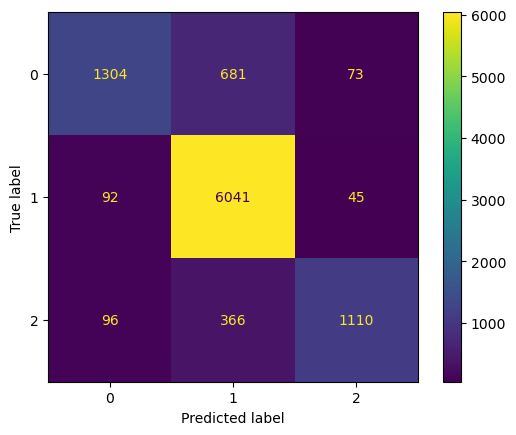

In [63]:
ConfusionMatrixDisplay.from_predictions(Ytrain, Ptrain)

In [64]:
def visualize(label):
    words = ""
    for msg in df[df["airline_sentiment"] == label]["cleaned_texts"]:
        words += msg + " "
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

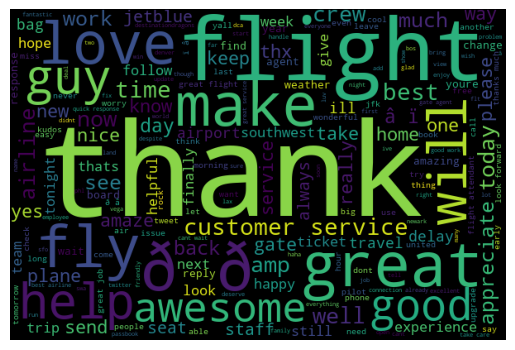

In [65]:
visualize("positive")

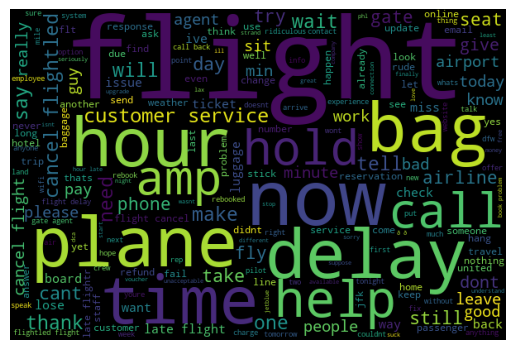

In [66]:
visualize("negative")

In [67]:
X = vectorizer.transform(df["cleaned_texts"])
df["predictions"] = model.predict(X)

In [86]:
sneaky_negative = df[(df["predictions"] == 2 & ((df["b_labels"] == 0) | (df["b_labels"] == 1)))]["cleaned_texts"]
for msg in sneaky_negative:
    print(msg)

you know that suicide the second leading cause death among teen
will you make bosgtlas non stop permanently anytime soon
amaze that cant get any cold air from the vent noair worstflightever roast sfotobos
lax ewr middle seat red eye such noob maneuver sendambien andchexmix
just bked cool birthday trip with you but cant add elevate cause enter middle name during flight book problem ð¢
this great news america could start flight hawaii end year via
nice vibe with the moodlight from takeoff touchdown moodlitmonday sciencebehindtheexperience
when can book flight hawaii
view downtown los angeles the hollywood sign and beyond that rain the mountain
plz help win bid upgrade for flight laxgtsea ð·ððºâï¸
flight leave dallas for seattle time feb
dream
after last night tribute soundofmusic think agree
all entertain
julie andrews all the way though very impressive
wish you fly out atlanta soon
julie andrews hand down
will flight leave dallas for february
you know need spotify stat guilt

In [87]:
sneaky_positive = df[(df["predictions"] == 1 & ((df["b_labels"] == 0) | (df["b_labels"] == 2)))]["cleaned_texts"]
for msg in sneaky_positive:
    print(msg)

what say
plus youve added commercial the experience tacky
didnt today must mean need take another trip
really miss prime opportunity for men without hat parody there
well didntâ¦but now
you miss dont worry well together very soon
amaze that cant get any cold air from the vent noair worstflightever roast sfotobos
just bked cool birthday trip with you but cant add elevate cause enter middle name during flight book problem ð¢
the hour operation for the club sfo that post online current
have unused ticket but move new city where you dont fly how can fly with you before expire travelhelp
flight way suppose take off minute ago website still show time not flight thanks
email your customer service team let know you need the tracking number
first time fly you all you have different ratepolicy for medium bag thanks
ive apply more then once member the inflight crew teamim interested flightattendant dreampath
fly but life happens and try change trip jperhi can you helpva home page will not let


# Binary Labels

In [70]:
data = df[(df["airline_sentiment"] == "positive") | (df["airline_sentiment"] == "negative")]["cleaned_texts"]
labels = df[(df["airline_sentiment"] == "positive") | (df["airline_sentiment"] == "negative")]["b_labels"].to_numpy()
train_x, test_x, Ytrain, Ytest = train_test_split(data, labels, test_size=0.33)

In [71]:
vectorizer = TfidfVectorizer(stop_words="english")
Xtrain = vectorizer.fit_transform(train_x)
Xtest = vectorizer.transform(test_x)

In [72]:
Xtrain

<7732x7132 sparse matrix of type '<class 'numpy.float64'>'
	with 57748 stored elements in Compressed Sparse Row format>

In [73]:
model = LogisticRegression(max_iter=1000)
model.fit(Xtrain, Ytrain)
print(f"train accuracy: {model.score(Xtrain, Ytrain)}")
print(f"test accuracy: {model.score(Xtest, Ytest)}")

train accuracy: 0.9127004655975168
test accuracy: 0.8955106327119979


In [74]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print(f"train f1 score: {f1_score(Ytrain, Ptrain)}")
print(f"test f1 score: {f1_score(Ytest, Ptest)}")

train f1 score: 0.9474585506343893
test f1 score: 0.9376371043560013


In [75]:
prob_train = model.predict_proba(Xtrain)[:, 1]
prob_test = model.predict_proba(Xtest)[:, 1]
print(f"train roc-auc score {roc_auc_score(Ytrain, prob_train)}")
print(f"test roc-auc score {roc_auc_score(Ytest, prob_test)}")

train roc-auc score 0.9785639810974676
test roc-auc score 0.9467924526692383


In [76]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[6086,   55],
       [ 620,  971]], dtype=int64)

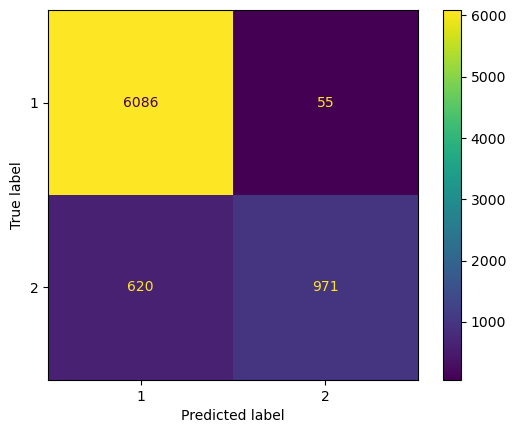

In [77]:
ConfusionMatrixDisplay.from_predictions(Ytrain, Ptrain)

In [78]:
def visualize(label):
    words = ""
    for msg in df[df["airline_sentiment"] == label]["cleaned_texts"]:
        words += msg + " "
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

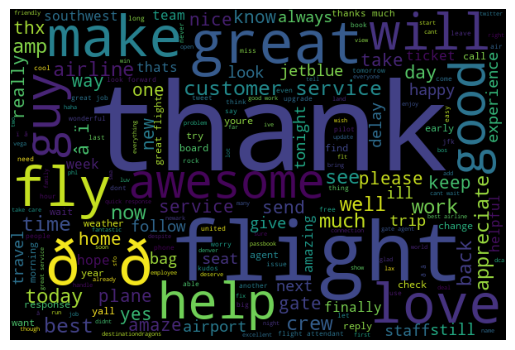

In [79]:
visualize("positive")

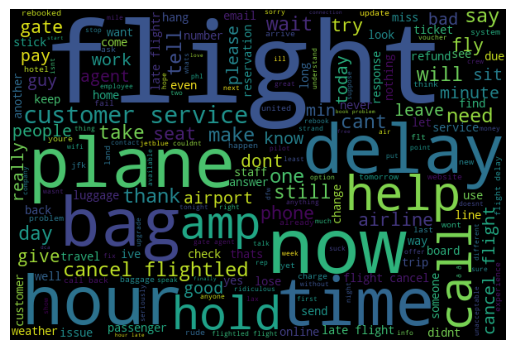

In [80]:
visualize("negative")

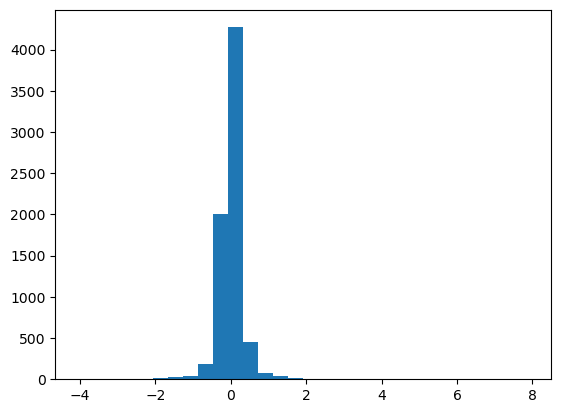

In [81]:
plt.hist(model.coef_[0], bins=30);

In [82]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'need': 4102,
 'register': 5090,
 'service': 5519,
 'dog': 1828,
 'class': 1093,
 'ticket': 6255,
 'sfo': 5540,
 'dull': 1903,
 'phone': 4623,
 'queue': 4940,
 'hour': 2953,
 'long': 3643,
 'pls': 4711,
 'advise': 97,
 'post': 4750,
 'response': 5197,
 'facebook': 2181,
 'people': 4581,
 'appal': 314,
 'lack': 3457,
 'concern': 1245,
 'love': 3677,
 'graphic': 2671,
 'thanks': 6180,
 'good': 2639,
 'military': 3917,
 'folk': 2419,
 'cold': 1164,
 'stlouis': 5907,
 'sure': 6019,
 'enjoy': 2019,
 'flight': 2331,
 'yes': 7076,
 'doesnt': 1825,
 'make': 3750,
 'mistake': 3966,
 'absurd': 28,
 'change': 999,
 'fact': 2184,
 'inconveniently': 3099,
 'miss': 3956,
 'luggage': 3707,
 'tonight': 6317,
 'quick': 4942,
 'finger': 2293,
 'cross': 1438,
 'plane': 4672,
 'dirty': 1735,
 'damn': 1516,
 'clean': 1101,
 'refund': 5080,
 'milesð': 3916,
 'wasteoftime': 6811,
 'theworst': 6211,
 'token': 6305,
 'goodwill': 2649,
 'voucher': 6758,
 'passenger': 4527,
 'stick': 5896,
 'phoenix': 4622,
 't

In [83]:
threshold = 2
print("Most positive words: ")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word, weight)

Most positive words: 
love 4.313628834933043
thanks 7.561482680683385
thank 7.901266849835961
awesome 4.455064821520674
wonderful 2.3280754775369012
cool 2.143263903613885
appreciate 2.5407522069658808
best 3.5962921791666562
great 4.926537315424444
excellent 2.6041244866946403
thx 2.9218861845918456
amazing 2.321075259767968
amaze 2.8948062380403154
kudos 2.3662326355065733


In [84]:
threshold = 2
print("Most negative words: ")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word, weight)

Most negative words: 
hour -4.060016389796462
flight -2.0332247415878326
bag -2.4369448977872104
delay -3.1705613966143664
bad -2.875662572806841
try -2.1377037753771355
sit -2.1210772858106957
pay -2.143648512415177
hold -2.763148576992737
dont -2.4364033778188854
cancel -2.5653620405795903
lose -2.0353871995102906
